# Disaster Tweet Classification with RNN Models

#### For this competition, we will be trying to classify tweets based on whether they are about a natural disaster or not. 
#### We'll build an RNN using the Tensorflow library and compare different architectures (Vanilla, LSTM, GRU, etc) as well as explore different embedding techniques to see if we can boost performance. 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import re
import string
import subprocess

import keras
import nltk.corpus
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer, SimpleRNN, LSTM, GRU, Dense, Embedding, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

try: 
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
[nltk_data] Downloading package wordnet to /kaggle/working/...


# EDA

## Data Exploration

#### First, we'll import the data and get some summary statistics about it. We'll also take a look at some example tweets from each class and figure out our plan of attack

In [2]:
train_path = '../input/nlp-getting-started/train.csv'
test_path = '../input/nlp-getting-started/test.csv'

train_raw = pd.read_csv(train_path)
test_raw = pd.read_csv(test_path)

In [3]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
train_raw.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
positive_examples = train_raw[train_raw['target'] == 1]
negative_examples = train_raw[train_raw['target'] == 0]

positive_examples['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [6]:
negative_examples['text'].head()

15                  What's up man?
16                   I love fruits
17                Summer is lovely
18               My car is so fast
19    What a goooooooaaaaaal!!!!!!
Name: text, dtype: object

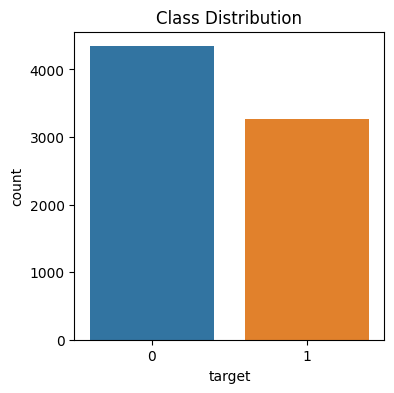

In [7]:
plt.figure(figsize=(4, 4))
sns.countplot(x='target', data=train_raw)
plt.title('Class Distribution')
plt.show()

## Analysis Plan

#### After looking through the data at a high-level, we can figure out a few different things that we need to do. The target classes aren't perfectly symmetrical but they are split roughly 60/40 so class imbalance shouldn't be a huge issue. We'll proceed through a few steps as we model:
* #### Our first step will be to clean the data -- this will include things like stripping out URLs and Stop-words, cleaning up repeated letters (check the 5th example in our negative classes above), and removing punctuation
* #### Next, we'll tokenize the input tweets, breaking them down into tokens for easier training
* #### We'll have to adress embedding schemes after tokenizing the data. We'll start with TF-IDF, and possibly try Word2Vec, and the built-in Tensorflow Embeddings Layer
* #### After we have the data processed, we'll fit a vanilla RNN to the data and test the performance.
* #### Once our baseline is established, we'll try other RNN architectures like LSTM, GRU, Bi-Directional
* #### Whichever base architecture performs the best, we'll run some hyperparameter tuning on to fine-tune it
* #### Once we've trained what we feel is our best model, we'll compare results and discuss what we've learned

# Data Cleaning and Pre-processing

## Cleaning Tweets

#### We'll create a few methods to handle stripping out punctuation, URLs, and stopwords. We'll also lemmatize the text here instead of tokenizing. We'll cover what our tokenization approach is in the next block

In [8]:
def clean_and_prep_text(df_text: pd.DataFrame):
    '''
    Given an input dataframe, transform the text column
    '''
    lemmatizer = WordNetLemmatizer()
    urlstr = re.compile(r"https?://\S+|www\.\S+")
    punctrans = str.maketrans("", "", string.punctuation)
    stop_set = set(stopwords.words("english"))
    
    df_text['no_url'] = df_text['text'].apply(lambda row: urlstr.sub(r"", row)) 
    df_text['no_punc'] = df_text['no_url'].apply(lambda row: row.translate(punctrans))
    df_text['clean'] = df_text['no_punc'].apply(lambda row: ' '.join([word.lower() for word in row.split() if word not in stop_set]))
    df_text['lemmas'] = df_text['clean'].apply(lambda row: ' '.join([lemmatizer.lemmatize(word) for word in row.split()]))

    df_text.drop(['no_url', 'no_punc', 'clean'], axis=1, inplace=True)

    return
    

## Tokenization

#### Next, we'll actually apply our cleaning to the data. We'll split into train/validation before applying our tokenization function since we want the encoding to be based only on the training data -- this will prevent leakage from the validation set

In [9]:
clean_and_prep_text(train_raw)

In [10]:
train_raw.head()

,id,keyword,location,text,target,lemmas
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all resident asked shelter place notified offi...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo ruby alaska smoke wildfire...


In [11]:
df_train, df_val = train_test_split(train_raw, test_size = 0.20, random_state=4022)

train_text = df_train.lemmas.to_numpy()
train_labels = df_train.target.to_numpy()

val_text = df_val.lemmas.to_numpy()
val_labels = df_val.target.to_numpy()

In [12]:
def count_words(df):
    count = Counter()
    for text in df.lemmas.values:
        for word in text.split():
            count[word] += 1
    return count

In [13]:
word_count = len(count_words(df_train))
print("There are: " + str(word_count) + " unique words in our training set")

There are: 14607 unique words in our training set


In [14]:
max_words = 25 # Roughly the number of words in an average 140 character tweet
tokenizer = Tokenizer(num_words=word_count)
tokenizer.fit_on_texts(train_text)

train_sequences = tokenizer.texts_to_sequences(train_text)
val_sequences = tokenizer.texts_to_sequences(val_text)

train_pad = pad_sequences(train_sequences, maxlen=max_words, padding='post', truncating='post')
val_pad = pad_sequences(val_sequences, maxlen=max_words, padding='post', truncating='post')

## Embedding the Text

#### We're just going to stick with the built-in embedding layer from Tensorflow. This makes it easy to add embeddings to our model, and gives us a hyperparameter to tune for better performance (the dimension of the embedding)

# Model Building and Training

## Basic Architecture

In [15]:
model_base = Sequential([
    InputLayer((max_words,)),
    # Layer one
    Embedding(word_count, 32, input_length=max_words),

    # Layer two
    SimpleRNN(units=32),

    # Output
    Dense(1, activation='sigmoid')
])

learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate = learning_rate)

model_base.compile(optimizer = opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])

model_base.build()
model_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 25, 32)              │         467,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 469,537 (1.79 MB)

 Trainable params: 469,537 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

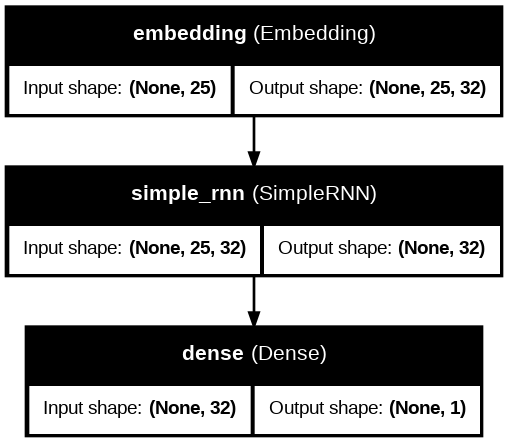

In [16]:
tf.keras.utils.plot_model(
    model_base,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

## Training and Exploring Results

In [17]:
base_history = model_base.fit(train_pad, train_labels, epochs=10, validation_data=(val_pad, val_labels))

base_metrics = pd.DataFrame(base_history.history)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6338 - loss: 0.6385 - val_accuracy: 0.7748 - val_loss: 0.5173
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8871 - loss: 0.3088 - val_accuracy: 0.7636 - val_loss: 0.5349
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9685 - loss: 0.1095 - val_accuracy: 0.7518 - val_loss: 0.6382
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9782 - loss: 0.0610 - val_accuracy: 0.7400 - val_loss: 0.6921
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9817 - loss: 0.0445 - val_accuracy: 0.7393 - val_loss: 0.7587
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9808 - loss: 0.0488 - val_accuracy: 0.7137 - val_loss: 0.8237
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9859 - loss: 0.0367 - val_accuracy: 0.7032 - val_loss: 0.8381
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9846 - loss: 0.0355 - val_accuracy: 0

<Axes: >

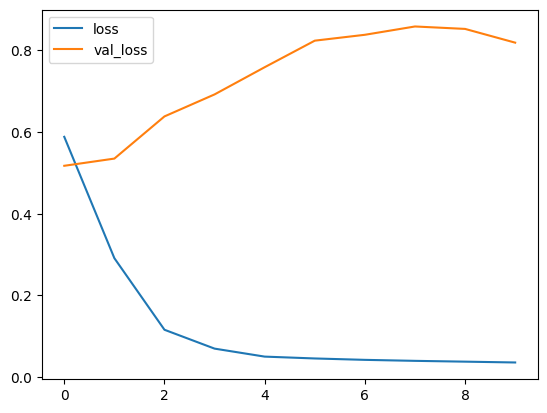

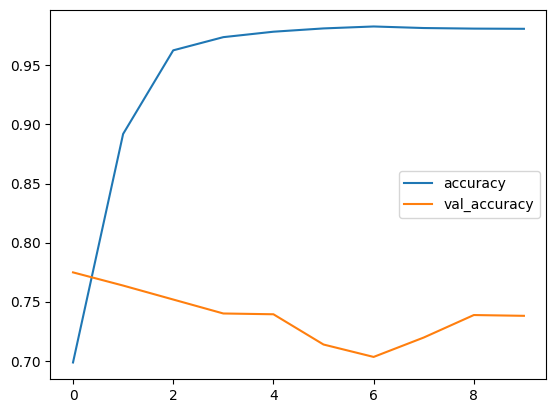

In [18]:
base_metrics[["loss","val_loss"]].plot()
base_metrics[['accuracy', 'val_accuracy']].plot()

## Hyperparameter Tuning and Other Architectures

# Submissions and Results

In [19]:
clean_and_prep_text(test_raw)
test_text = test_raw.lemmas.to_numpy()
test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = pad_sequences(test_sequences, max_words, padding='post', truncating='post')
ids = test_raw.id

In [20]:
predictions = model_base.predict(test_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [21]:
submission_df = pd.DataFrame({
    'id': ids,
    'target': predictions
})

In [22]:
submission_df.to_csv('submission.csv', index=False)

## Comparing Models

In [23]:
#def plot_graphs(history, metric):
#  plt.plot(history.history[metric])
#  plt.plot(history.history['val_'+metric], '')
#  plt.xlabel("Epochs")
#  plt.ylabel(metric)
#  plt.legend([metric, 'val_'+metric])

## Conclusions